# Wind Power Prediction

## Part 1: Exploratory Data Analysis (EDA)

1. Data Cleaning:
    * Handled null values by dropping or imputing.
    * Ensured `Time` column was properly parsed into a datetime object
2. Key Visualizations:
    * Distribution of `Power`
    * Correlation heatmap to identify key predictors
    * Time series plot for temperature
    * Scatter plots to evaluate relationschip between predictors (`WS_100m`, `Temp_2m`) and target (`Power`)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

   Unnamed: 0              Time  Location  Temp_2m  RelHum_2m      DP_2m  \
0           0  02-01-2013 00:00         1  28.2796  84.664205  24.072595   
1           1  02-01-2013 01:00         1  28.1796  85.664205  24.272595   
2           2  02-01-2013 02:00         1  26.5796  90.664205  24.072595   
3           3  02-01-2013 03:00         1  27.1796  87.664205  23.872595   
4           4  02-01-2013 04:00         1  27.0796  87.664205  23.672595   

     WS_10m   WS_100m      WD_10m     WD_100m    WG_10m     Power  
0  1.605389  1.267799  145.051683  161.057315  1.336515  0.163496  
1  2.225389  3.997799  150.051683  157.057315  4.336515  0.142396  
2  1.465389  2.787799  147.051683  149.057315  3.136515  0.121396  
3  1.465389  2.697799   57.051683  104.057315  1.536515  0.100296  
4  2.635389  4.437799   57.051683   83.057315  3.936515  0.079296  
Unnamed: 0    0
Time          0
Location      0
Temp_2m       0
RelHum_2m     0
DP_2m         0
WS_10m        0
WS_100m       0
WD_10m 

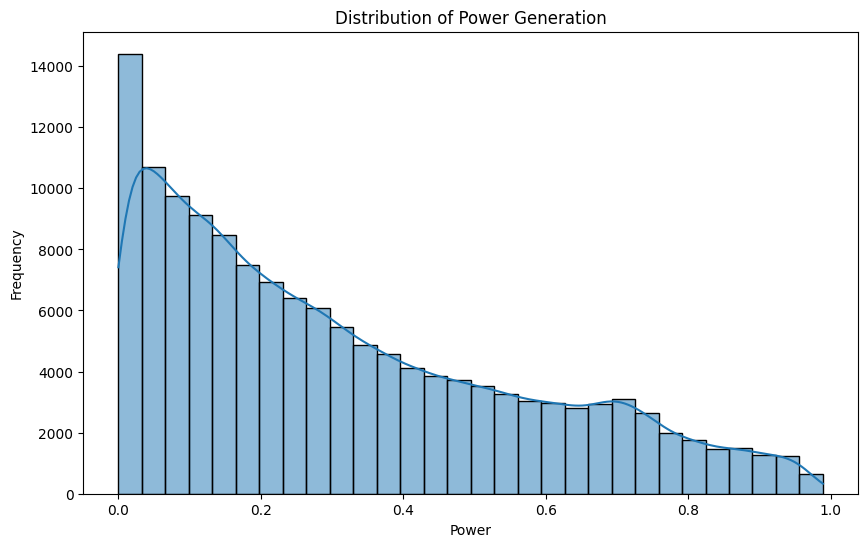

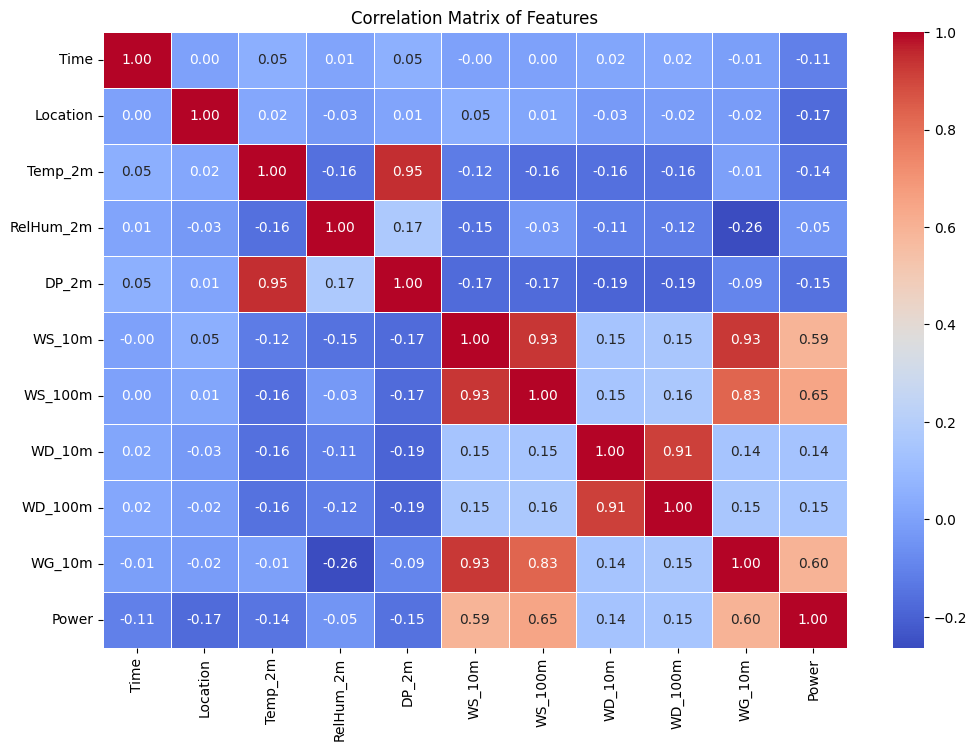

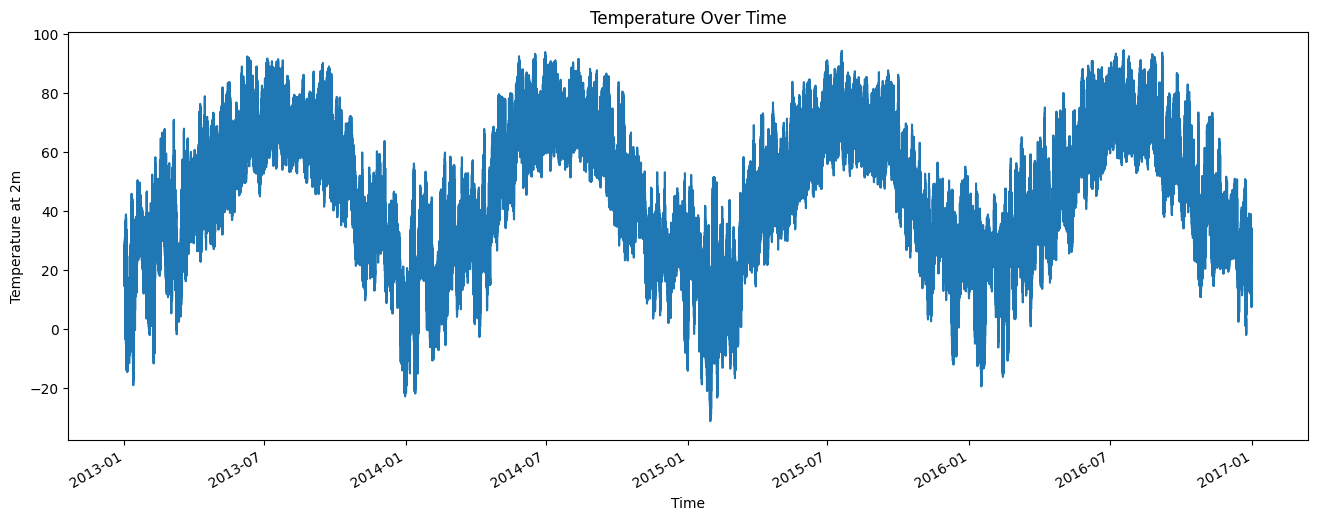

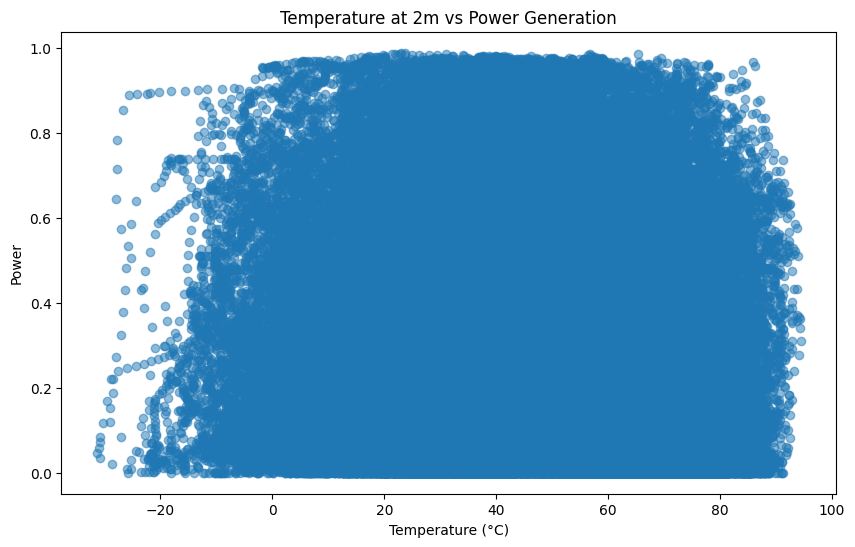

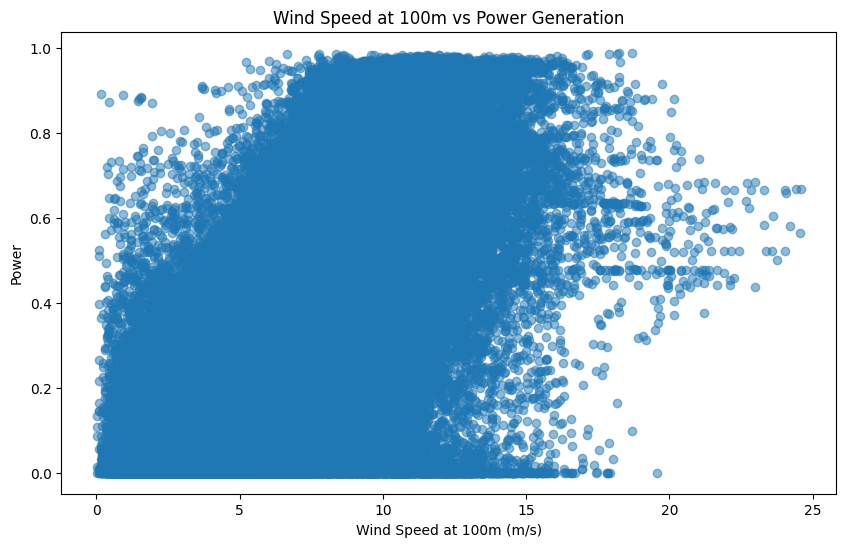

In [2]:
df_train = pd.read_csv("./windturbine/Train.csv")
print(df_train.head())
print(df_train.isnull().sum())

df_train['Time'] = pd.to_datetime(df_train['Time'], format='%d-%m-%Y %H:%M')
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)

print("\nTrain Dataset Info:")
print(df_train.info())

# 1. Distribution of Power
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Power'], kde=True, bins=30)
plt.title('Distribution of Power Generation')
plt.xlabel('Power')
plt.ylabel('Frequency')
plt.show()

# 2. Correlation Heatmap
plt.figure(figsize=(12, 8))
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

# 3. Temperature over time
plt.figure(figsize=(16, 6))
df_train.set_index('Time')['Temp_2m'].plot()
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature at 2m')
plt.show()

# 4. Temperature vs. Power (Scatter Plot)
plt.figure(figsize=(10, 6))
plt.scatter(df_train['Temp_2m'], df_train['Power'], alpha=0.5)
plt.title('Temperature at 2m vs Power Generation')
plt.xlabel('Temperature (°C)')
plt.ylabel('Power')
plt.show()

# 5. Wind Speed at 100m vs Power
plt.figure(figsize=(10, 6))
plt.scatter(df_train['WS_100m'], df_train['Power'], alpha=0.5)
plt.title('Wind Speed at 100m vs Power Generation')
plt.xlabel('Wind Speed at 100m (m/s)')
plt.ylabel('Power')
plt.show()

### Findings:
1. Power generation is skewed with most values clustering near zero.
2. Correlation heatmap shows strong positive correlation between wind speed at 100m (WS_100m) and power.
3. Scatter plots indicate non-linear relationships between wind speed/temperature and power generation.

## Part 2: Model Development and Comparison

1. Preprocessing:
    * Standardized features
    * Performed feature selection based on Random Forest importance scores
2. Implemented Models:
    * **Linear Regression:** Simple baseline
    * **Random Forest:** Tuned for depth and estimators
    * **Gradient Boosting:** Leveraged to capture non-linear relationships
3. Evaluation Metrics:
    * Mean Squared Error (MSE)
    * R² score for explained variance

In [3]:
features = df_train.drop(columns=['Time', 'Power'])
target = df_train['Power']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Linear Regression

In [4]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_y_pred = lr_model.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_rmse = np.sqrt(lr_mse)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Linear Regression Mean Squared Error: {lr_mse}')
print(f'Linear Regression Root Mean Squared Error: {lr_rmse}')
print(f'Linear Regression R² Score: {lr_r2}')

Linear Regression Mean Squared Error: 0.03313575330900837
Linear Regression Root Mean Squared Error: 0.18203228644668606
Linear Regression R² Score: 0.4847233435618622


### Random Forest Regression

In [5]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_rmse = np.sqrt(rf_mse)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f'Random Forest Mean Squared Error: {rf_mse}')
print(f'Random Forest Root Mean Squared Error: {rf_rmse}')
print(f'Random Forest R² Score: {rf_r2}')

Random Forest Mean Squared Error: 0.02015483595385753
Random Forest Root Mean Squared Error: 0.141967728564831
Random Forest R² Score: 0.6865827559580637


#### Hyperparameter Tuning

In [6]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search_rf.fit(X_train, y_train)

print(f"Best Parameters for Random Forest: {grid_search_rf.best_params_}")
print(f"Best RMSE from GridSearchCV: {np.sqrt(-grid_search_rf.best_score_)}")

best_rf_model = grid_search_rf.best_estimator_
best_rf_y_pred = best_rf_model.predict(X_test)
best_rf_mse = mean_squared_error(y_test, best_rf_y_pred)
best_rf_rmse = np.sqrt(best_rf_mse)
best_rf_r2 = r2_score(y_test, best_rf_y_pred)

print(f'Tuned Random Forest Mean Squared Error: {best_rf_mse}')
print(f'Tuned Random Forest Root Mean Squared Error: {best_rf_rmse}')
print(f'Tuned Random Forest R² Score: {best_rf_r2}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}
Best RMSE from GridSearchCV: 0.14236597891420866
Tuned Random Forest Mean Squared Error: 0.01997615387790161
Tuned Random Forest Root Mean Squared Error: 0.14133702231864662
Tuned Random Forest R² Score: 0.6893613468597217


### Gradient Boosting Regression

In [7]:
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_test)

gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_rmse = np.sqrt(gb_mse)
gb_r2 = r2_score(y_test, gb_y_pred)

print(f'Gradient Boosting Mean Squared Error: {gb_mse}')
print(f'Gradient Boosting Root Mean Squared Error: {gb_rmse}')
print(f'Gradient Boosting R² Score: {gb_r2}')

Gradient Boosting Mean Squared Error: 0.02519536022373635
Gradient Boosting Root Mean Squared Error: 0.15873046406955518
Gradient Boosting R² Score: 0.6082002164619014


### An Ensemble of Random Forest and Gradient Boosting models

In [8]:
rf_weight = 0.6
gb_weight = 0.4

ensemble_pred = (rf_weight * rf_y_pred) + (gb_weight * gb_y_pred)

ensemble_mse = mean_squared_error(y_test, ensemble_pred)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_r2 = r2_score(y_test, ensemble_pred)

print(f'Ensemble Model Mean Squared Error: {ensemble_mse}')
print(f'Ensemble Model Root Mean Squared Error: {ensemble_rmse}')
print(f'Ensemble Model R² Score: {ensemble_r2}')

Ensemble Model Mean Squared Error: 0.021161710773844083
Ensemble Model Root Mean Squared Error: 0.14547065262053402
Ensemble Model R² Score: 0.670925375669885


### Feature Engineering and Selection

In [9]:
feature_importances = pd.Series(rf_model.feature_importances_, index=features.columns).sort_values(ascending=False)
print(feature_importances)

top_features = feature_importances.index[:5]
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

rf_model_top = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_top.fit(X_train_top, y_train)
rf_top_y_pred = rf_model_top.predict(X_test_top)

rf_top_mse = mean_squared_error(y_test, rf_top_y_pred)
rf_top_rmse = np.sqrt(rf_top_mse)
rf_top_r2 = r2_score(y_test, rf_top_y_pred)

print(f'Top Features Random Forest Mean Squared Error: {rf_top_mse}')
print(f'Top Features Random Forest Root Mean Squared Error: {rf_top_rmse}')
print(f'Top Features Random Forest R^2 Score: {rf_top_r2}')

WS_100m      0.509495
Location     0.123500
Temp_2m      0.065073
DP_2m        0.060419
WG_10m       0.055481
WS_10m       0.048595
RelHum_2m    0.048313
WD_100m      0.045100
WD_10m       0.044025
dtype: float64
Top Features Random Forest Mean Squared Error: 0.02395949637261002
Top Features Random Forest Root Mean Squared Error: 0.15478855375191675
Top Features Random Forest R^2 Score: 0.6274184846292954


### Results Evaluation

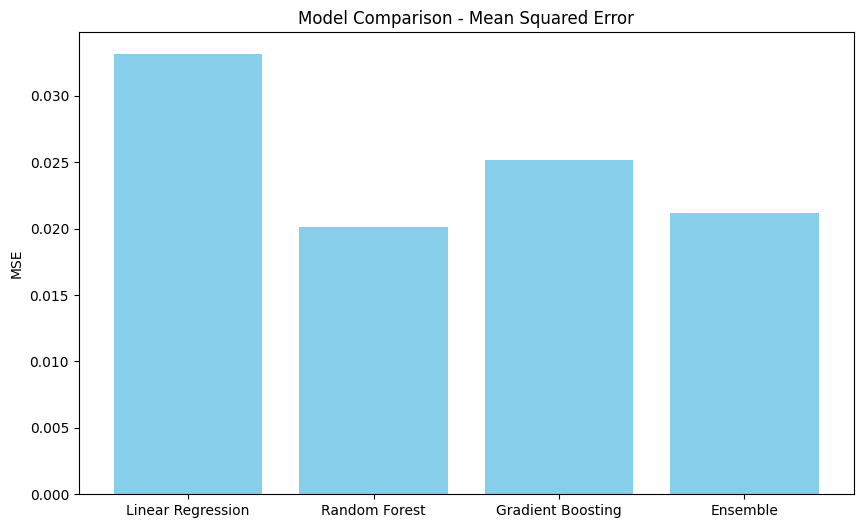

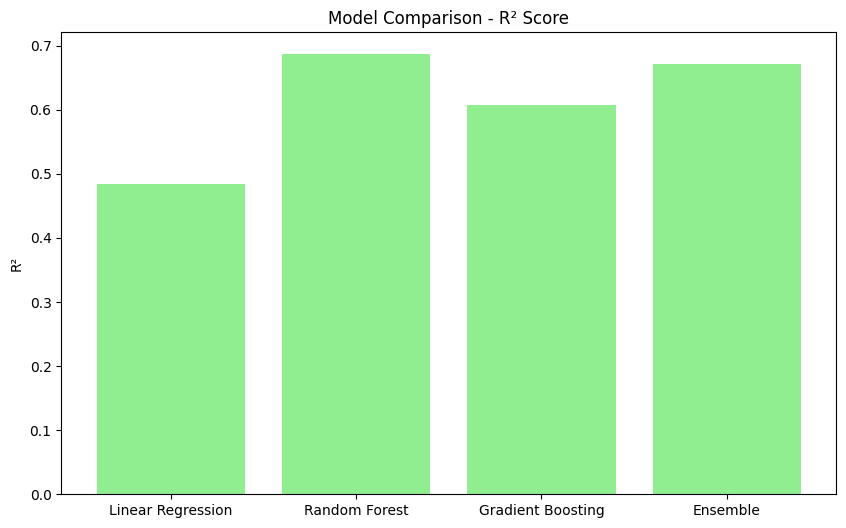

In [10]:
models = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Ensemble']
mse_values = [lr_mse, rf_mse, gb_mse, ensemble_mse]
r2_values = [lr_r2, rf_r2, gb_r2, ensemble_r2]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color='skyblue')
plt.title('Model Comparison - Mean Squared Error')
plt.ylabel('MSE')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen')
plt.title('Model Comparison - R² Score')
plt.ylabel('R²')
plt.show()

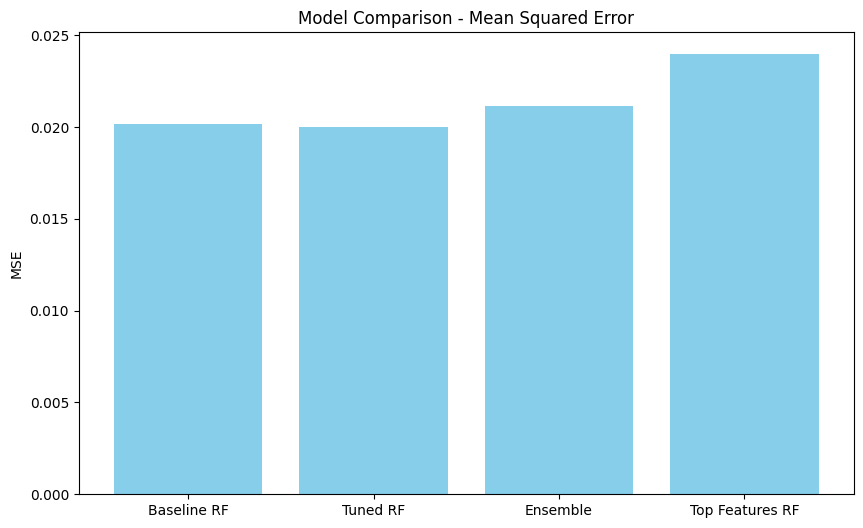

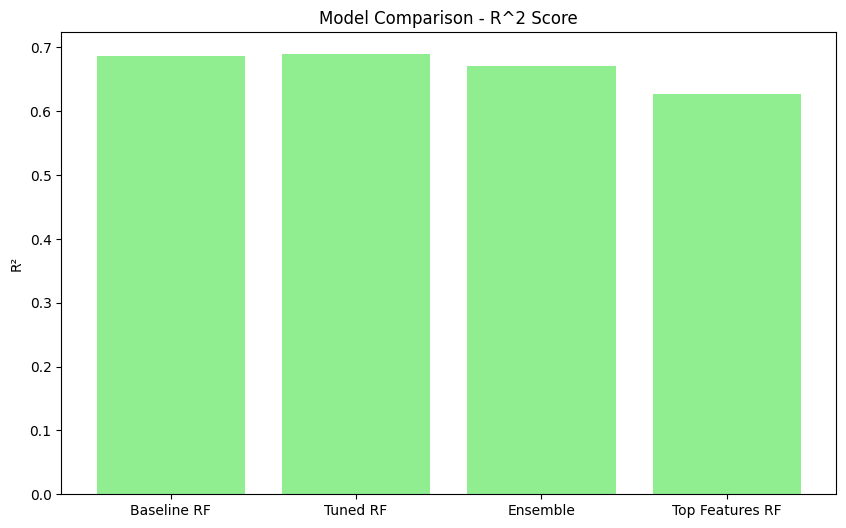

In [11]:
models = ['Baseline RF', 'Tuned RF', 'Ensemble', 'Top Features RF']
mse_values = [rf_mse, best_rf_mse, ensemble_mse, rf_top_mse]
r2_values = [rf_r2, best_rf_r2, ensemble_r2, rf_top_r2]

plt.figure(figsize=(10, 6))
plt.bar(models, mse_values, color='skyblue')
plt.title('Model Comparison - Mean Squared Error')
plt.ylabel('MSE')
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(models, r2_values, color='lightgreen')
plt.title('Model Comparison - R^2 Score')
plt.ylabel('R²')
plt.show()